In [4]:
%load_ext google.cloud.bigquery

# Performing Basic Feature Engineering in BQML 

## Introduction 
In this Notebook, we utilize feature engineering to improve the prediction of the fare amount for a taxi ride in New York City.  We will use BigQuery ML to build a taxifare prediction model, using feature engineering to improve and create a final model.

In this Notebook we set up the environment, create the project dataset, create a feature engineering table, create and evaluate a baseline model, extract temporal features, perform a feature cross on temporal features, and evaluate model performance throughout the process. 

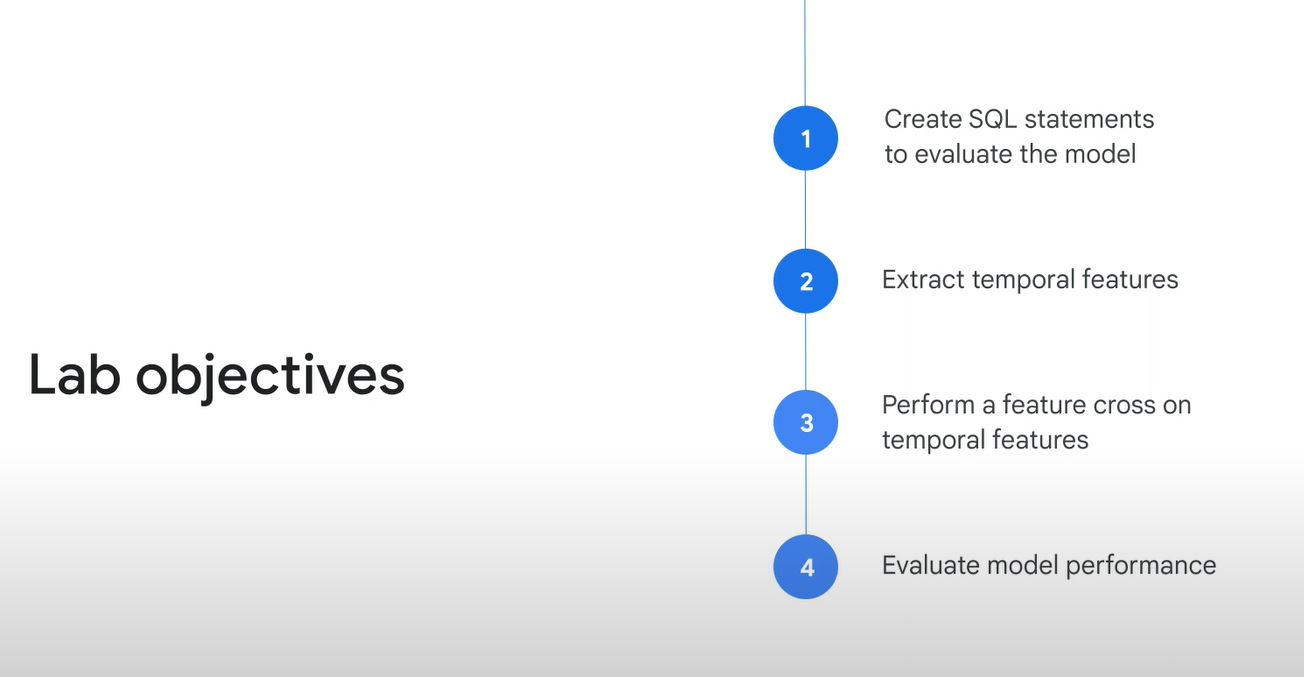

### Set up environment variables and load necessary libraries

In [1]:
# Installing the latest version of the package
!pip install --user google-cloud-bigquery==3.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.1/215.1 kB 2.2 MB/s eta 0:00:00a 0:00:01
DEPRECATION: nb-black 1.0.7 has a non-standard dependency specifier black>='19.3'; python_version >= "3.6". pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nb-black or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-aiplatform 1.20.0 requires google-cloud-bigquery<3.0.0dev,>=1.15.0, but you have google-cloud-bigquery 3.4.1 which is incompatible.
pandas-gbq 0.18.1 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.


**Note**: Restart your kernel to use updated packages.

Kindly ignore the deprecation warnings and incompatibility errors related to google-cloud-storage.

In [1]:
# Installing the latest version of the package
import tensorflow as tf
print("TensorFlow version: ",tf.version.VERSION)

2024-01-12 20:54:44.431670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 20:54:44.738266: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-12 20:54:44.738280: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-01-12 20:54:44.780295: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 20:54:45.741743: W tensorflow/stream_executor/platform/de

TensorFlow version:  2.10.1


In [ ]:
%%bash
# Exporting the project

export PROJECT=$(gcloud config list project --format "value(core.project)")
echo "Your current GCP Project Name is: "$PROJECT

## The source dataset

Our dataset is hosted in [BigQuery](https://cloud.google.com/bigquery/). The taxi fare data is a publically available dataset, meaning anyone with a GCP account has access. Click [here](https://console.cloud.google.com/bigquery?project=bigquery-public-data&p=nyc-tlc&d=yellow&t=trips&page=table) to access the dataset.

The Taxi Fare dataset is large but simple to understand, with only six features. The `fare_amount` is the target, the continuous value we’ll train a model to predict.

In [5]:
%%bigquery

SELECT COUNT(*)
FROM `nyc-tlc.yellow.trips`

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,1108779463


As we can see the dataset has over a billion rows.

## Create a BigQuery Dataset

A BigQuery dataset is a container for tables, views, and models built with BigQuery ML. Let's create one called __feat_eng__ if we have not already done so in an earlier lab. We'll do the same for a GCS bucket for our project too.

In [ ]:
%%bash

# Create a BigQuery dataset for feat_eng if it doesn't exist
datasetexists=$(bq ls -d | grep -w feat_eng)

if [ -n "$datasetexists" ]; then
    echo -e "BigQuery dataset already exists, let's not recreate it."

else
    echo "Creating BigQuery dataset titled: feat_eng"
    
    bq --location=US mk --dataset \
        --description 'Taxi Fare' \
        $PROJECT:feat_eng
   echo "\nHere are your current datasets:"
   bq ls
fi    

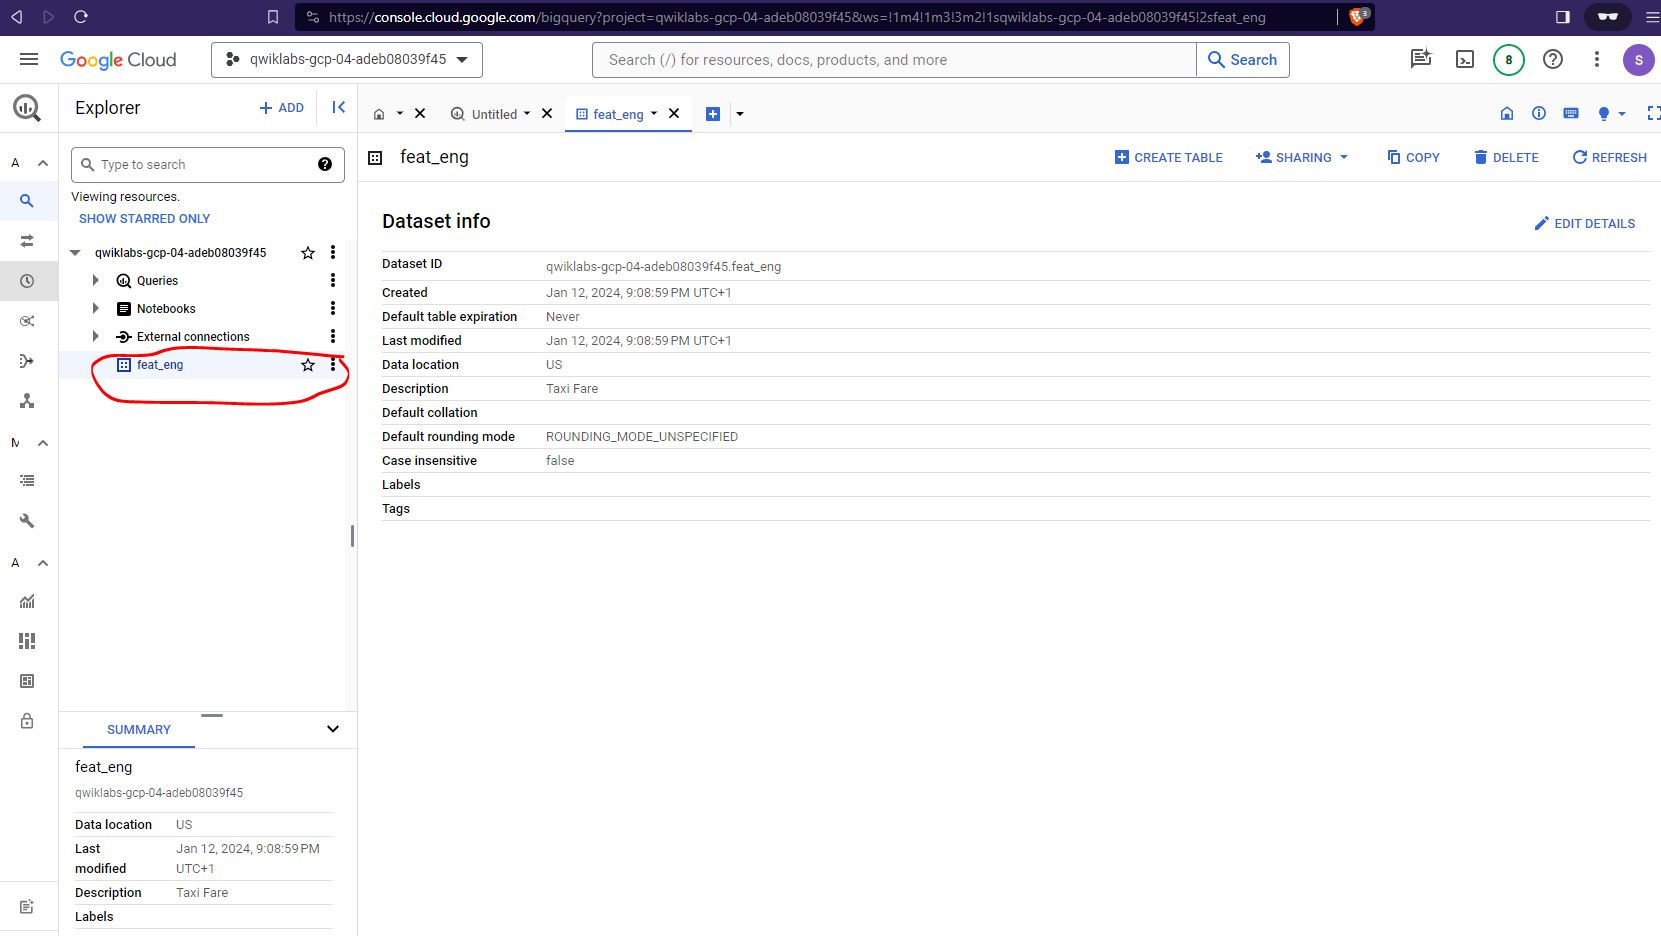

### A repeatable way to split your data set

For machine learning, you want repeatable sampling of the data you have in BigQuery. One way to achieve this is to use the last few digits of the HASH function on the field that you are using to split your data.

Let’s say you want to split up your data by date and get approximately 80% of the days in the data set:

This is now repeatable—because the HASH function returns the same value any time it is invoked on a specific date, you can be sure you will get the same 80% of data each time. If you want to split your data by arrival_airport (so that 80% of airports are in the training data set), compute the HASH on arrival_airport instead of date.

It is also pretty clear what you have to do to get the validation data: change the < 8 in the query above to ==8, and for testing data, change it to == 9. This way, you get 10% of samples in validation and 10% in testing.

### Repeatable sampling

This is good if you want 80% of the entire data set as training, but what if you want a smaller data set than what you have in BigQuery to play around with? The flights data is 70 million rows, and perhaps what you want is a small data set of perhaps a million flights. How would you pick one in 70 flights, and then 80% of those as training?

Where the 700 is 70*10 and 560 is 70*8. The first modulo operation picks one in 70 rows and the second modulo operation picks 8 in 10 of those rows.

For validation data, you’d replace < 560 by the appropriate range:

Note: In the code above, your one million flights come from only 1/70th of the days in the data set. This may be precisely what you want—for example, you may be modeling the full spectrum of flights on a particular day when experimenting with the smaller data set. However, if what you want is 1/70th of the flights on any particular day, use RAND() (as shown in the first code sample) and save the result as a new BigQuery table (for repeatability). From this smaller table, you can sample 80% of dates using HASH(). Because this new table is only one million rows and only for experimentation, the duplication may be acceptable.

## Create the training data table

Since there is already a publicly available dataset, we can simply create the training data table using this raw input data.  Note the WHERE clause in the below query:  This clause allows us to TRAIN a portion of the data (e.g. one hundred thousand rows versus one million rows), which keeps your query costs down. 

**Note:**  The dataset in the create table code below is the one created previously, e.g. "feat_eng".  The table name is "feateng_training_data".  **Run the query to create the table**.

In [ ]:
%%bigquery 

CREATE OR REPLACE TABLE
  feat_eng.feateng_training_data AS
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  passenger_count*1.0 AS passengers,
  pickup_datetime,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat
FROM
  `nyc-tlc.yellow.trips`
WHERE
  MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), 10000) = 1  # 
  AND fare_amount >= 2.5
  AND passenger_count > 0
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45

## Verify table creation

Verify that you created the dataset.


In [4]:
%%bigquery

# LIMIT 0 is a free query; this allows us to check that the table exists.
SELECT
*
FROM
  feat_eng.feateng_training_data
LIMIT
  0

,fare_amount,passengers,pickup_datetime,pickuplon,pickuplat,dropofflon,dropofflat


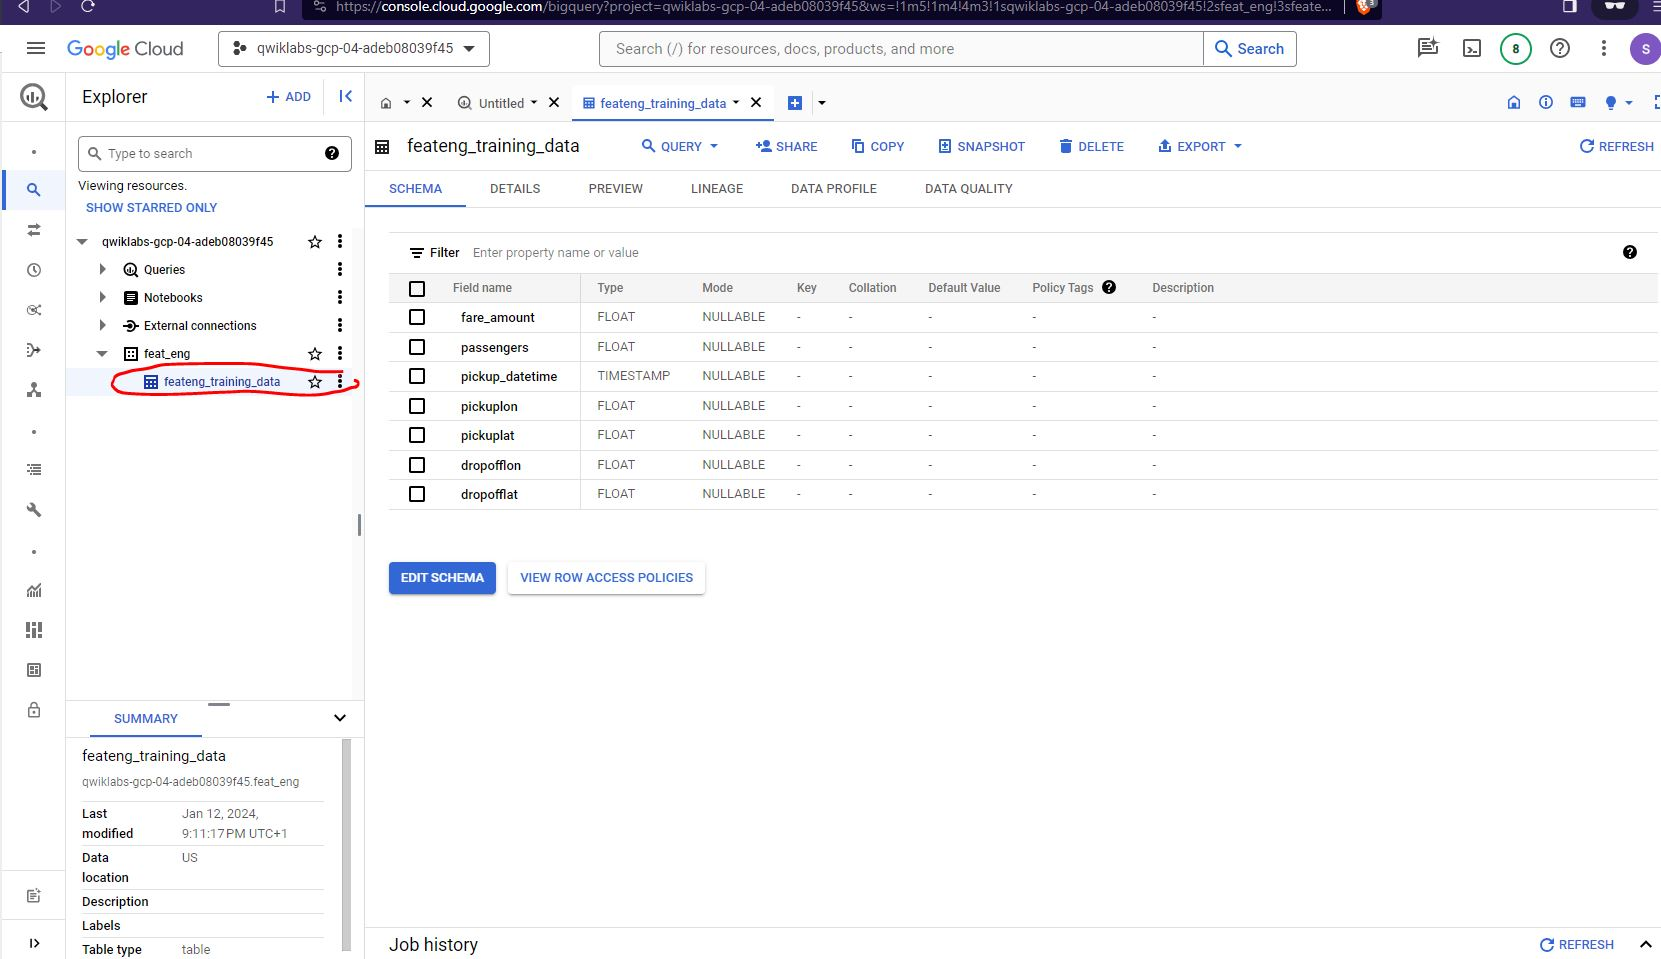

### Baseline Model:  Create the baseline model

Next, you create a linear regression baseline model with no feature engineering.  Recall that a model in BigQuery ML represents what an ML system has learned from the training data.  A baseline model is a solution to a problem without applying any machine learning techniques.  

When creating a BQML model, you must specify the model type (in our case linear regression) and the input label (fare_amount).  Note also that we are using the training data table as the data source.

Now we create the SQL statement to create the baseline model.

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL
  feat_eng.baseline_model OPTIONS (model_type='linear_reg',
    input_label_cols=['fare_amount']) AS
SELECT
  fare_amount,
  passengers,
  pickup_datetime,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
FROM
  feat_eng.feateng_training_data

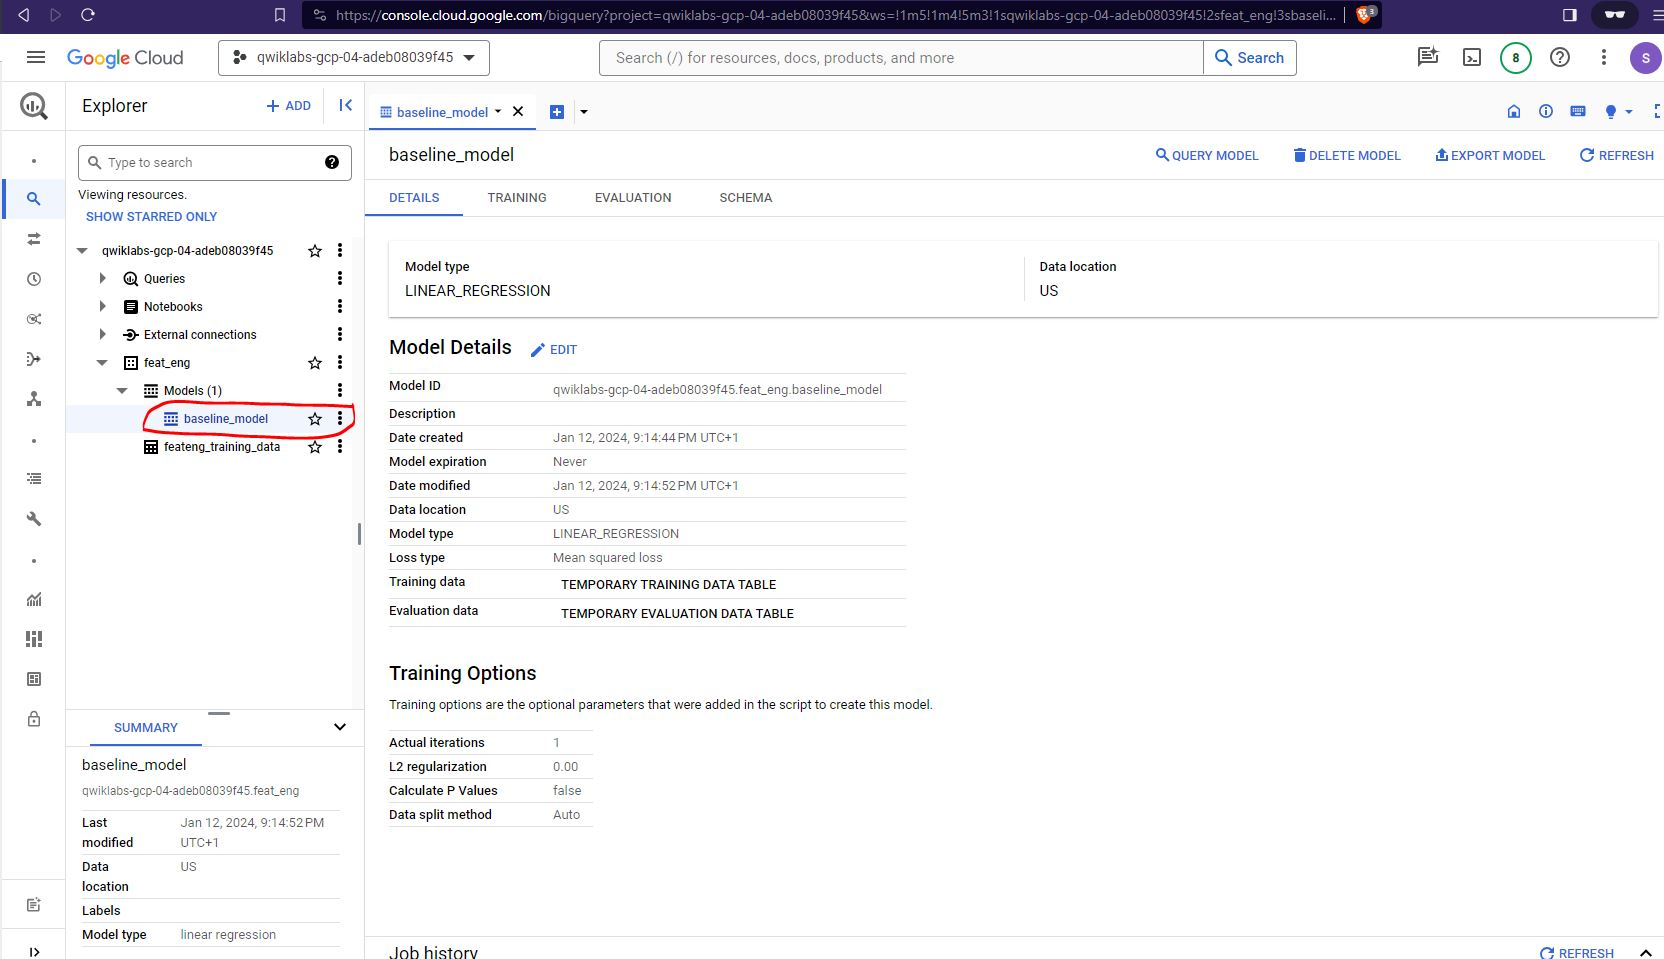

Note, the query takes several minutes to complete. After the first iteration is complete, your model (baseline_model) appears in the navigation panel of the BigQuery web UI. Because the query uses a CREATE MODEL statement to create a model, you do not see query results.

You can observe the model as it's being trained by viewing the Model stats tab in the BigQuery web UI. As soon as the first iteration completes, the tab is updated. The stats continue to update as each iteration completes.

Once the training is done, visit the [BigQuery Cloud Console](https://console.cloud.google.com/bigquery) and look at the model that has been trained. Then, come back to this notebook.

### Evaluate the baseline model
Note that BigQuery automatically split the data we gave it, and trained on only a part of the data and used the rest for evaluation.  After creating your model, you evaluate the performance of the regressor using the ML.EVALUATE function. The ML.EVALUATE function evaluates the predicted values against the actual data.

NOTE: The results are also displayed in the [BigQuery Cloud Console](https://console.cloud.google.com/bigquery) under the **Evaluation** tab.

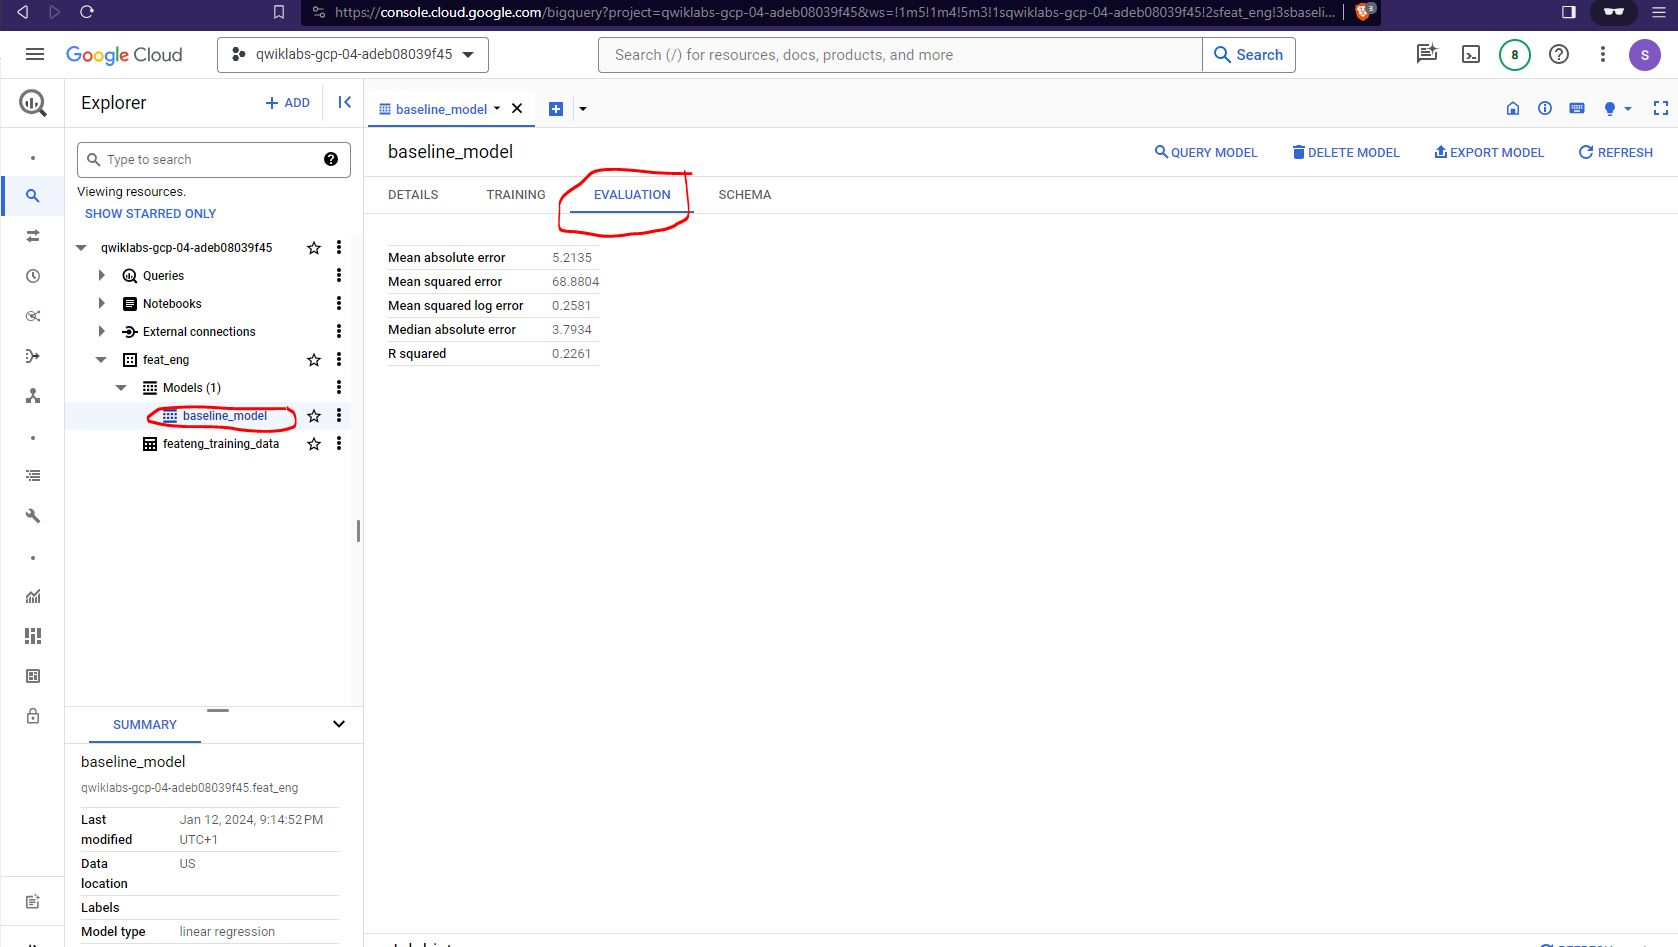

Review the learning and eval statistics for the baseline_model.

In [6]:
%%bigquery

# Eval statistics on the held out data.
# Here, ML.EVALUATE function is used to evaluate model metrics
SELECT
  *,
  SQRT(loss) AS rmse
FROM
  ML.TRAINING_INFO(MODEL feat_eng.baseline_model)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,rmse
0,0,0,74.43591,68.880408,None,12426,8.627625


In [7]:
%%bigquery

# Here, ML.EVALUATE function is used to evaluate model metrics
SELECT
  *
FROM
  ML.EVALUATE(MODEL feat_eng.baseline_model)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,5.213479,68.880408,0.258098,3.794535,0.226065,0.22613


**NOTE:** Because you performed a linear regression, the results include the following columns:

*   mean_absolute_error
*   mean_squared_error
*   mean_squared_log_error
*   median_absolute_error
*   r2_score
*   explained_variance

**Resource** for an explanation of the [Regression Metrics](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234).

**Mean squared error** (MSE) - Measures the difference between the values our model predicted using the test set and the actual values. You can also think of it as the distance between your regression (best fit) line and the predicted values. 

**Root mean squared error** (RMSE) - The primary evaluation metric for this ML problem is the root mean-squared error. RMSE measures the difference between the predictions of a model, and the observed values. A large RMSE is equivalent to a large average error, so smaller values of RMSE are better. One nice property of RMSE is that the error is given in the units being measured, so you can tell very directly how incorrect the model might be on unseen data.

**R2**:  An important metric in the evaluation results is the R2 score. The R2 score is a statistical measure that determines if the linear regression predictions approximate the actual data. Zero (0) indicates that the model explains none of the variability of the response data around the mean.  One (1) indicates that the model explains all the variability of the response data around the mean.

Next, we write a SQL query to take the SQRT() of the mean squared error as your loss metric for evaluation for the benchmark_model.

In [8]:
%%bigquery

# Here, ML.EVALUATE function is used to evaluate model metrics
SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL feat_eng.baseline_model)

,rmse
0,8.299422


#### Model 1:  EXTRACT dayofweek from the pickup_datetime feature.

* As you recall, dayofweek is an enum representing the 7 days of the week. This factory allows the enum to be obtained from the int value. The int value follows the ISO-8601 standard, from 1 (Monday) to 7 (Sunday).

* If you were to extract the dayofweek from pickup_datetime using BigQuery SQL, the datatype returned would be integer.

Next, we create a model titled "model_1" from the benchmark model and extract out the DayofWeek.

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL
  feat_eng.model_1 OPTIONS (model_type='linear_reg',
    input_label_cols=['fare_amount']) AS
SELECT
  fare_amount,
  passengers,
  pickup_datetime,
  EXTRACT(DAYOFWEEK
  FROM
    pickup_datetime) AS dayofweek,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
FROM
  feat_eng.feateng_training_data

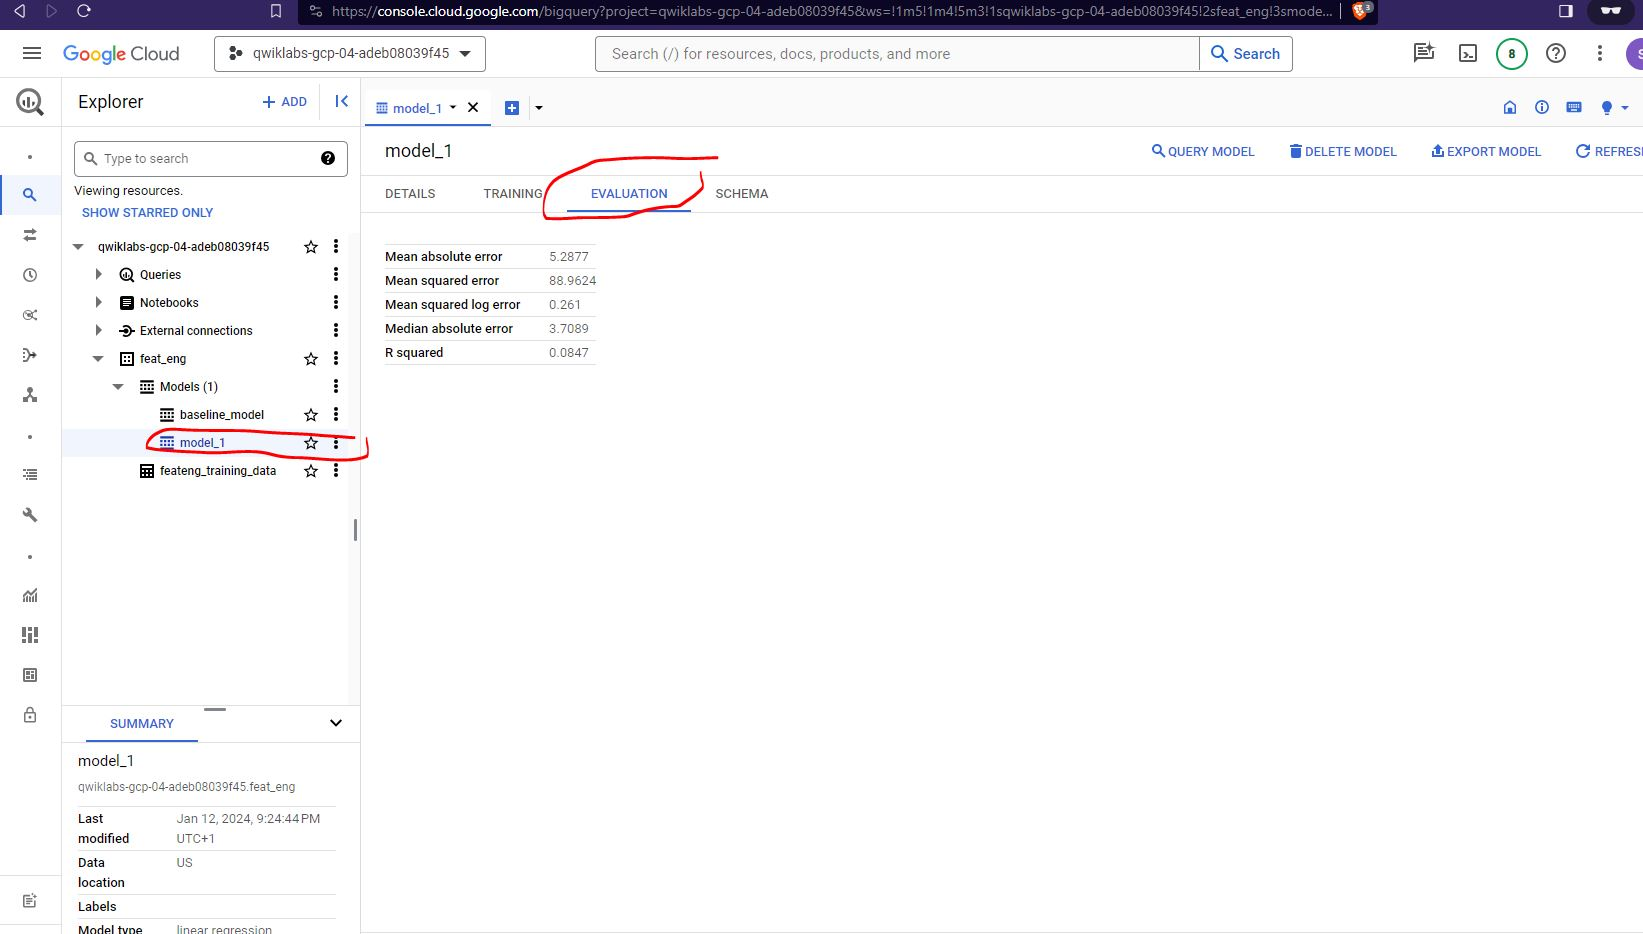

Once the training is done, visit the [BigQuery Cloud Console](https://console.cloud.google.com/bigquery) and look at the model that has been trained. Then, come back to this notebook.

Next, two distinct SQL statements show the TRAINING and EVALUATION metrics of model_1.

In [104]:
%%bigquery

# Here, ML.TRAINING_INFO function is used to see information about the training iterations of a model.
SELECT
  *,
  SQRT(loss) AS rmse
FROM
  ML.TRAINING_INFO(MODEL feat_eng.model_1)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,rmse
0,0,0,72.440724,88.953232,None,17251,8.511212


In [108]:
%%bigquery

# Here, ML.EVALUATE function is used to evaluate model metrics
SELECT
  *
FROM
  ML.EVALUATE(MODEL feat_eng.model_1)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,5.287076,88.953232,0.260932,3.713439,0.08481,0.084811


Here we run a SQL query to take the SQRT() of the mean squared error as your loss metric for evaluation for the benchmark_model.

In [117]:
%%bigquery

# Here, ML.EVALUATE function is used to evaluate model metrics
SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL feat_eng.model_1)

,rmse
0,9.431502


### Model 2:  EXTRACT hourofday from the pickup_datetime feature

As you recall, **pickup_datetime** is stored as a TIMESTAMP, where the Timestamp format is retrieved in the standard output format – year-month-day hour:minute:second (e.g. 2016-01-01 23:59:59).  Hourofday returns the integer number representing the hour number of the given date.

Hourofday is best thought of as a discrete ordinal variable (and not a categorical feature), as the hours can be ranked (e.g. there is a natural ordering of the values).  Hourofday has an added characteristic of being cyclic, since 12am follows 11pm and precedes 1am.

Next, we create a model titled "model_2" and EXTRACT the hourofday from the pickup_datetime feature to improve our model's rmse.

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL
  feat_eng.model_2 OPTIONS (model_type='linear_reg',
    input_label_cols=['fare_amount']) AS
SELECT
  fare_amount,
  passengers,
  #pickup_datetime,
  EXTRACT(DAYOFWEEK
  FROM
    pickup_datetime) AS dayofweek,
  EXTRACT(HOUR
  FROM
    pickup_datetime) AS hourofday,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
FROM
  `feat_eng.feateng_training_data`

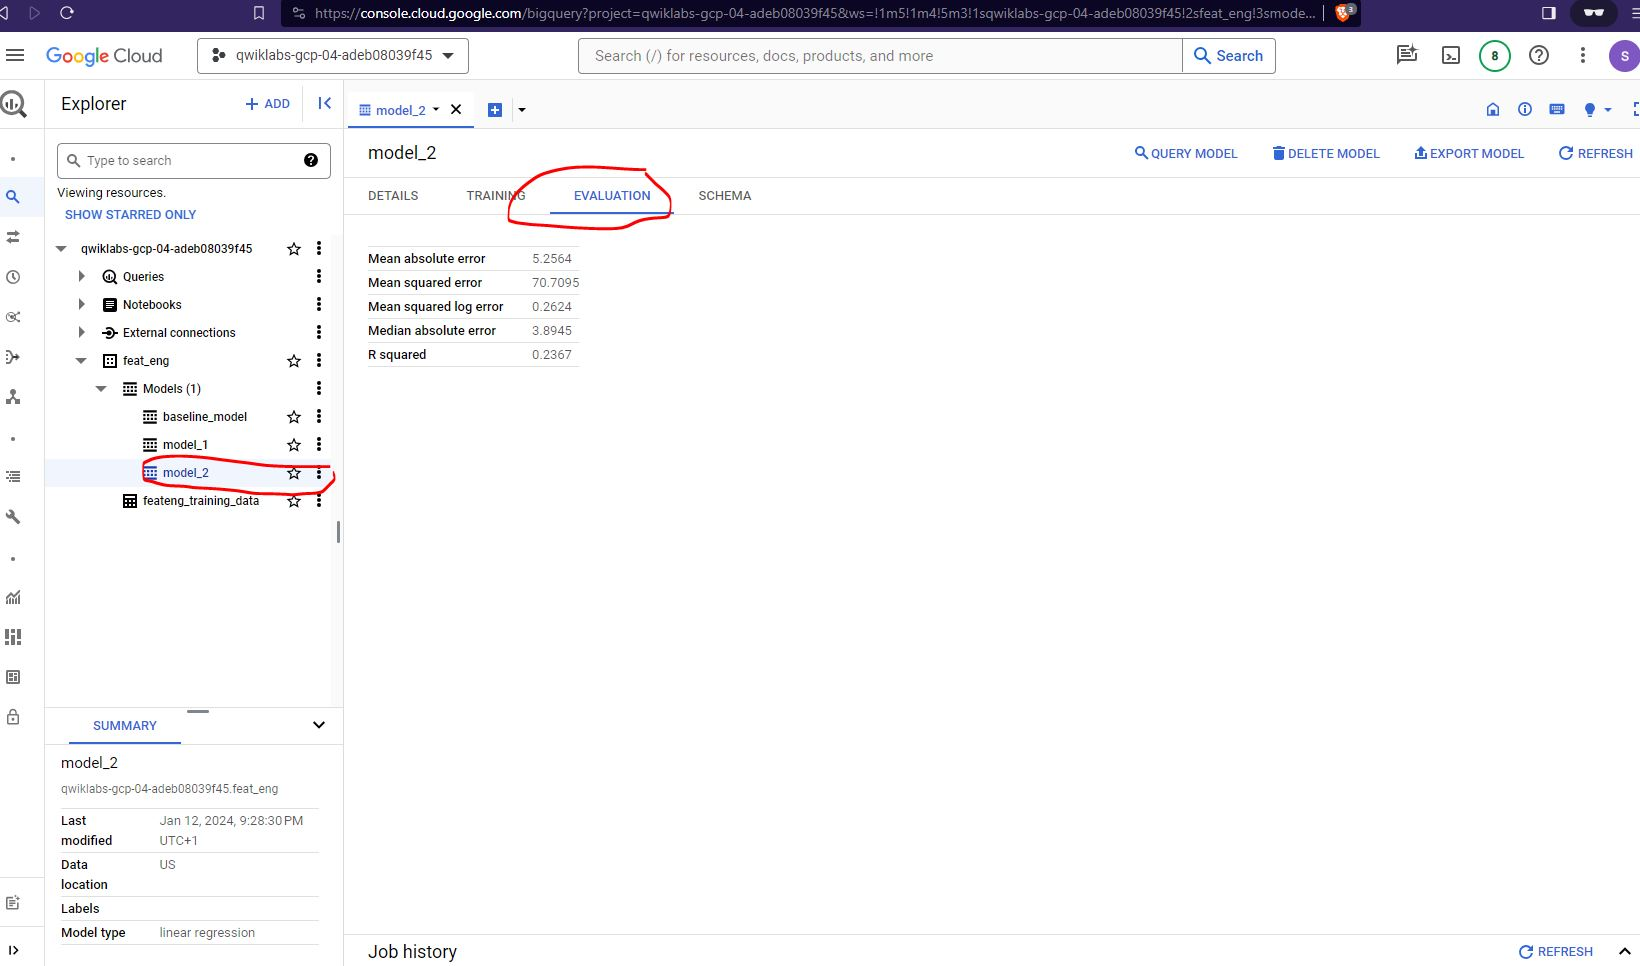

In [12]:
%%bigquery

# Here, ML.EVALUATE function is used to evaluate model metrics
SELECT
  *
FROM
  ML.EVALUATE(MODEL feat_eng.model_2)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,5.256421,70.709518,0.262399,3.895416,0.236668,0.236768


In [13]:
%%bigquery

# Here, ML.EVALUATE function is used to evaluate model metrics
SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL feat_eng.model_2)

,rmse
0,8.408895


### Model 3:  Feature cross dayofweek and hourofday using CONCAT

First, let’s allow the model to learn traffic patterns by creating a new feature that combines the time of day and day of week (this is called a [feature cross](https://developers.google.com/machine-learning/crash-course/feature-crosses/video-lecture). 

Note:  BQML by default assumes that numbers are numeric features, and strings are categorical features.  We need to convert both the dayofweek and hourofday features to strings because the model (Neural Network) will automatically treat any integer as a numerical value rather than a categorical value.  Thus, if not cast as a string, the dayofweek feature will be interpreted as numeric values (e.g. 1,2,3,4,5,6,7) and hourofday will also be interpreted as numeric values (e.g. the day begins at midnight, 00:00, and the last minute of the day begins at 23:59 and ends at 24:00).  As such, there is no way to distinguish the "feature cross" of hourofday and dayofweek "numerically".  Casting the dayofweek and hourofday as strings ensures that each element will be treated like a label and will get its own coefficient associated with it.

Create the SQL statement to feature cross the dayofweek and hourofday using the CONCAT function.  Name the model "model_3"

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL
  feat_eng.model_3 OPTIONS (model_type='linear_reg',
    input_label_cols=['fare_amount']) AS
SELECT
  fare_amount,
  passengers,
  #pickup_datetime,
  #EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  #EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  CONCAT(CAST(EXTRACT(DAYOFWEEK
      FROM
        pickup_datetime) AS STRING), CAST(EXTRACT(HOUR
      FROM
        pickup_datetime) AS STRING)) AS hourofday,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
FROM
  `feat_eng.feateng_training_data`

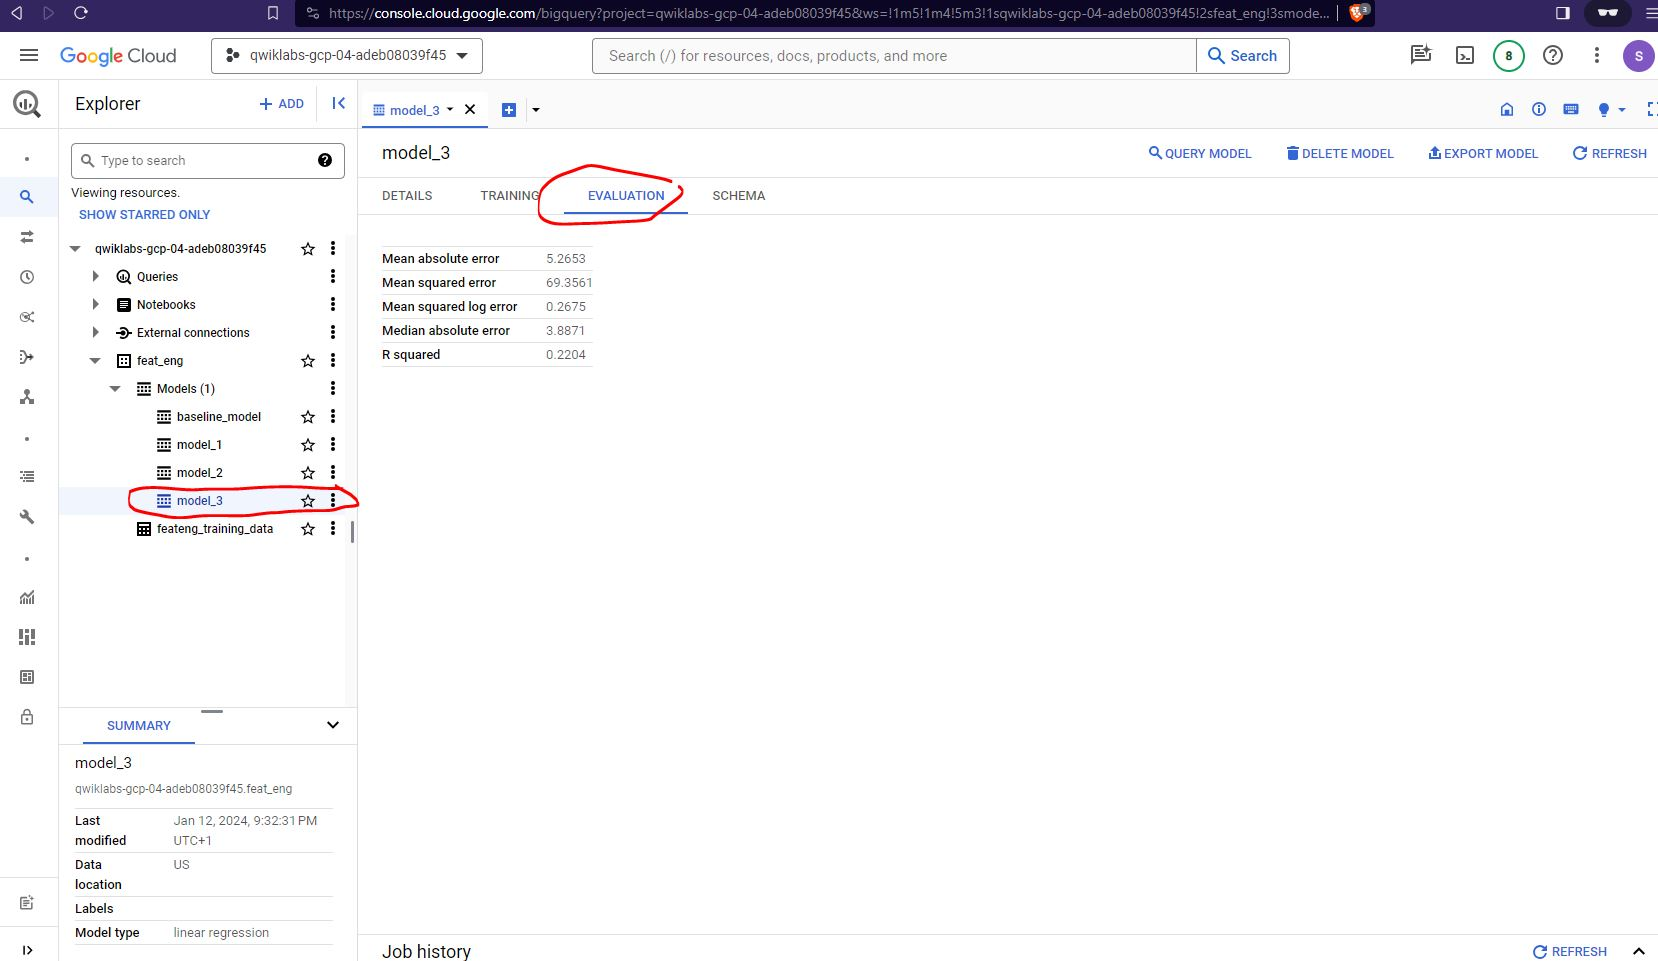

In [15]:
%%bigquery

# Here, ML.EVALUATE function is used to evaluate model metrics
SELECT
  *
FROM
  ML.EVALUATE(MODEL feat_eng.model_3)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,5.265321,69.356068,0.267477,3.887588,0.220371,0.220574


In [16]:
%%bigquery

# Here, ML.EVALUATE function is used to evaluate model metrics
SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL feat_eng.model_3)

,rmse
0,8.328029


### Create a RMSE summary table to evaluate model performance.

Markdown table generator: http://www.tablesgenerator.com/markdown_tables

| Model          | Taxi Fare | Description                                  |
|----------------|-----------|----------------------------------------------|
| baseline_model | 8.62      | Baseline model - no feature engineering    |
| model_1        | 9.43      | EXTRACT dayofweek from the pickup_datetime |
| model_2        | 8.40      | EXTRACT hourofday from the pickup_datetime |
| model_3        | 8.32      | FEATURE CROSS hourofday and dayofweek      |